# Measurements of Relativistic Biases

Start in the appropriate notebook directory.

In [1]:
# %cd /mnt/lustre/mikewang/projects/HorizonGRound/notebooks/

Set up the appropriate paths.

In [2]:
import os, sys

current_file_dir = os.getcwd()
sys.path.insert(0, "".join([current_file_dir, "/../"]))
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

from config.program import data_dir, stylesheet

publication_dir = data_dir/"output"/"publication"

Import the appropriate packages.

In [3]:
import glob
import re
from collections import defaultdict

import corner
import h5py
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import AutoMinorLocator

plt.style.use(stylesheet)

## Number density quantiles

Load samples of the relativistic bias parameters at densly sampled redshifts and determine their quantiles.

In [4]:
extracted_chain_files = glob.glob(
    "/".join([str(publication_dir), "dense_points", "density", "numden_z*"])
)

In [5]:
quantile_levels = [0.022750, 0.158655, 0.5, 0.841345, 0.977250]

In [6]:
dense_redshifts = []
nbar_quantiles = defaultdict(list)
for chain_file in sorted(extracted_chain_files):
    dense_redshifts.append(float(
        re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')
    ))
    with h5py.File(chain_file, 'r') as chain_data:
        extracts = chain_data['extract/chain'][()]
        nbar_q = corner.quantile(extracts, q=quantile_levels)
    for sigma_level_idx, sigma_level in enumerate([-2, -1, 0, 1, 2]):
        nbar_quantiles[sigma_level].append(nbar_q[sigma_level_idx])

Separate the high redshift part and the low redshift partat the pivot redshift.

In [7]:
discontinuity_pos = np.searchsorted(dense_redshifts, 2.2)

if dense_redshifts[discontinuity_pos] == 2.2:
    del dense_redshifts[discontinuity_pos]
    for sigma_level in nbar_quantiles:
        del nbar_quantiles[sigma_level][discontinuity_pos]

low_redshift_part = slice(0, discontinuity_pos)
high_redshift_part = slice(discontinuity_pos, None)

## Relativistic bias measurements

Load samples of the relativistic bias parameters in eBOSS QSO LF redshift bins and determine the estimates with uncertainties.

In [8]:
measured_chain_files = glob.glob(
    "/".join([str(publication_dir), "eBOSS_binning", "numden_z*"])
)

In [9]:
estimate_levels = [0.158655, 0.5, 0.841345]

In [10]:
measured_redshifts = []
nbar_estimates = defaultdict(list)
for chain_file in sorted(measured_chain_files):
    measured_redshifts.append(float(
        re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')
    ))
    with h5py.File(chain_file, 'r') as chain_data:
        extracts = chain_data['extract/chain'][()]
        nbar_e = corner.quantile(extracts, q=estimate_levels)
    for sigma_level_idx, sigma_level in enumerate([-1, 0, 1]):
        nbar_estimates[sigma_level].append(nbar_e[sigma_level_idx])

## Relativistic bias constraints

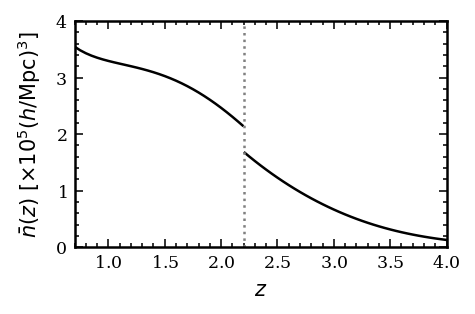

In [31]:
ALPHA = 0.5
SCALING = 10 ** 5

fig = plt.figure("comoving number density", figsize=(3.2, 2.), dpi=150)

ax = plt.subplot2grid((1, 1), (0, 0))

for part in [low_redshift_part, high_redshift_part]:
    ax.plot(
        dense_redshifts[part], SCALING * np.asarray(nbar_quantiles[0])[part],
        c='k'
    )

# ax.errorbar(
#     measured_redshifts, SCALING * np.asarray(nbar_estimates[0]),
#     yerr=[
#         SCALING * np.subtract(nbar_estimates[0], nbar_estimates[-1]),
#         SCALING * np.subtract(nbar_estimates[1], nbar_estimates[0]),
#     ],
#     fmt='s', zorder=3
# )
# for part in [low_redshift_part, high_redshift_part]:
#     ax.fill_between(
#         dense_redshifts[part], 
#         SCALING * np.asarray(nbar_quantiles[-2][part]),
#         SCALING * np.asarray(nbar_quantiles[2][part]),
#         facecolor='0.67', alpha=ALPHA, zorder=1
#     )

ax.axvline(x=2.2, ls=':', c='0.5')

ax.set_yticks(np.arange(0., 5., step=1.))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim(min(dense_redshifts), max(dense_redshifts))
ax.set_ylim(0., 4.)
ax.set_xlabel(r"$z$")
ax.set_ylabel(r"$\bar{n}(z)\ [\times 10^5 (h/\mathrm{Mpc})^3]$", labelpad=6)

fig.savefig(publication_dir/"gallery"/"number_density.pdf")